In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import HTML

# Dataset path
FILENAME = "dataset/dataset_Abu Dhabi_2025.csv"

In [21]:
def summarize_f1_regression(results):
    """
    Generates a stylized HTML summary for regression results.
    Significant variables are highlighted, and coefficients are color-coded.
    """
    table = results.summary2().tables[1]
    # Drop confidence intervals for a cleaner summary
    table = table.drop(columns=['[0.025', '0.975]'], errors='ignore')

    rows = []
    for idx, row in table.iterrows():
        coef = row['Coef.']
        pval = row['P>|t|']
        
        # Apply transparency to non-significant variables (p > 0.05)
        opacity = "opacity: 0.4;" if pval > 0.05 else ""
        
        # Color coding for coefficients: green for positive impact, red for negative
        coef_color = '#2ecc71' if coef >= 0 else '#e74c3c'
        
        coef_html = f'<td style="color: {coef_color}; font-weight: bold; text-align: right;">{coef:.4f}</td>'
        pval_html = f'<td style="font-weight: bold; text-align: right;">{pval:.3f}</td>'
        
        html_row = (
            f'<tr style="{opacity}">'
            f'<th style="text-align: left; padding-right: 20px;">{idx}</th>'
            f'{coef_html}'
            f'<td style="text-align: right;">{row["Std.Err."]:.4f}</td>'
            f'<td style="text-align: right;">{row["t"]:.2f}</td>'
            f'{pval_html}</tr>'
        )
        rows.append(html_row)

    header = (
        "<tr style='background-color: ##ffffff;'>"
        "<th>Variable</th><th>Coef. (Delta km/h)</th><th>Std.Err.</th><th>t-stat</th><th>P>|t|</th>"
        "</tr>"
    )
    
    html_table = (
        f"<table border='1' style='border-collapse: collapse; width: 100%; font-family: sans-serif;'>"
        f"<thead>{header}</thead><tbody>{''.join(rows)}</tbody></table>"
    )

    return HTML(html_table)

In [22]:
# 1. LOAD DATASET
try:
    df_final = pd.read_csv(FILENAME)
    print(f"Dataset loaded successfully: {len(df_final)} rows")
except FileNotFoundError:
    print(f"Error: the file {FILENAME} was not found")

# 2. PRELIMINARY VARIABLE PREPARATION
# Define target
y = df_final['Speed']

# Create an initial version of X for diagnostics (Heatmap)
# We drop non-numerical or non-causal columns
initial_drops = ['X_Coord', 'Y_Coord', 'Compound', 'Team']
X_initial = df_final.drop(columns=[c for c in initial_drops if c in df_final.columns])

# Encode drivers for the correlation matrix (temporary X)
X_diag = pd.get_dummies(X_initial, columns=['Driver'], drop_first=True).astype(float)

Dataset loaded successfully: 197838 rows


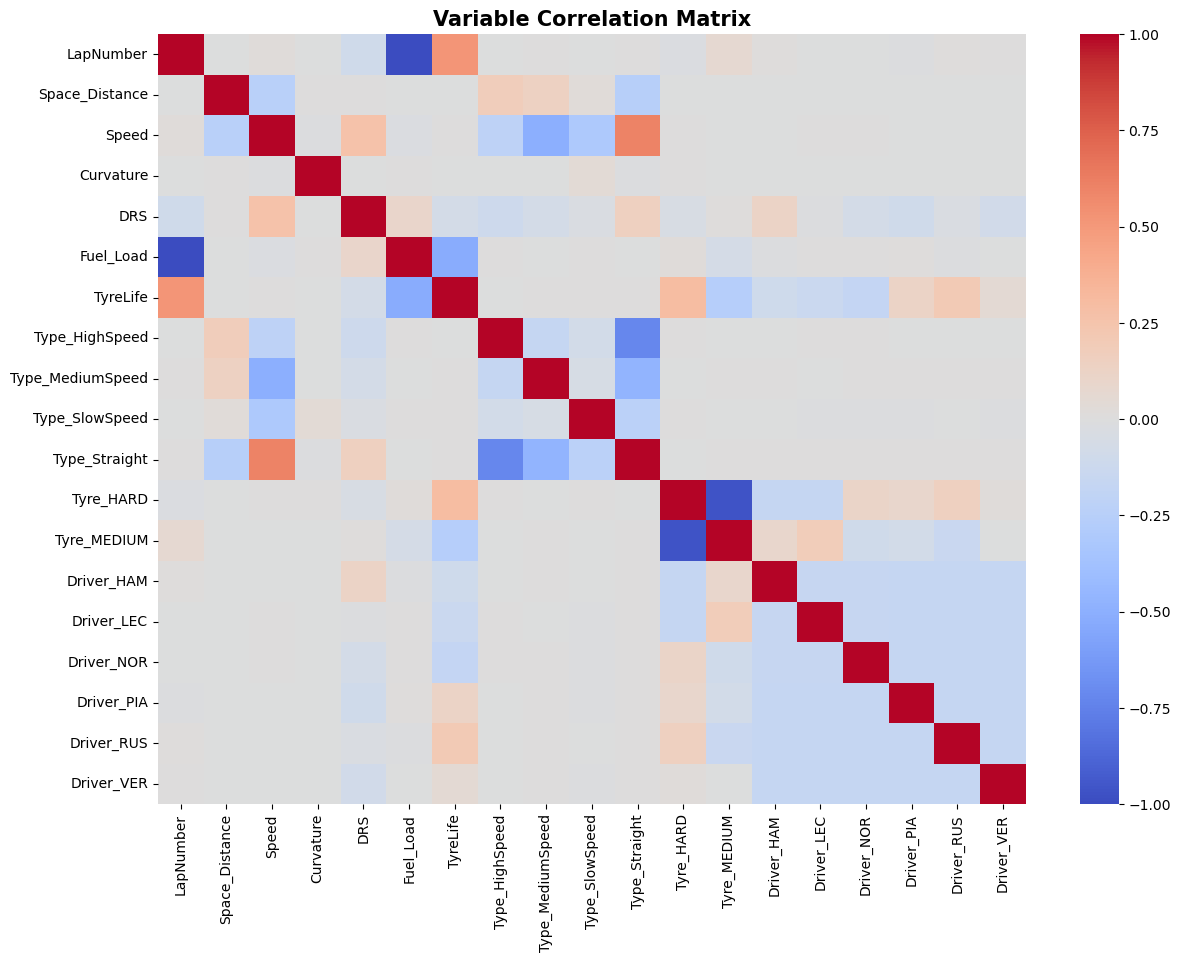

In [23]:
# 3. CORRELATION MATRIX HEATMAP
plt.figure(figsize=(14, 10))

# Calculate correlation matrix
corr_matrix = X_diag.corr()

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Variable Correlation Matrix", fontsize=15, fontweight='bold')
plt.show()

In [24]:
# 4. MODEL FITTING
# Dropping redundant or highly collinear features 
cols_to_drop = [
    'Speed', 'Curvature', 'Type_Straight', 'Type_Hairpin', 
    'Tyre_MEDIUM', 'Tyre_SOFT', 'LapNumber', 'Space_Distance', 
    'X_Coord', 'Y_Coord', 'Compound', 'Team'
]

X_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])

# Dummy encoding for categorical variable 'Driver'
X_final = pd.get_dummies(X_final, columns=['Driver'])
# Setting Hamilton as the baseline reference by dropping his column
if 'Driver_HAM' in X_final.columns:
    X_final = X_final.drop(columns=['Driver_HAM'])

# Add intercept and ensure float type 
X_final = sm.add_constant(X_final).astype(float)
final_model_obj = sm.OLS(y, X_final)
final_results = final_model_obj.fit()

display(summarize_f1_regression(final_results))
r2_score = final_results.rsquared
rse_score = np.sqrt(final_results.scale)

print(f"\nModel performance metrics:")
print(f"- R-squared: {r2_score:.3f}")
print(f"- Residual Standard Error (RSE): {rse_score:.3f} km/h")

Variable,Coef. (Delta km/h),Std.Err.,t-stat,P>|t|
const,256.5612,0.4126,621.81,0.000
DRS,50.8871,0.4581,111.08,0.000
Fuel_Load,-0.0845,0.0038,-22.42,0.000
TyreLife,-0.0506,0.0138,-3.66,0.000
Type_HighSpeed,-47.7423,0.2480,-192.53,0.000
Type_MediumSpeed,-115.3064,0.3332,-346.06,0.000
Type_SlowSpeed,-141.0442,0.6263,-225.19,0.000
Tyre_HARD,1.1817,0.2199,5.37,0.000
Driver_ANT,3.0887,0.3671,8.41,0.000
Driver_LEC,4.2109,0.3687,11.42,0.000



Model performance metrics:
- R-squared: 0.506
- Residual Standard Error (RSE): 43.168 km/h


Sì, il risultato di **+1.0448 km/h** per la mescola **Hard** rispetto alla **Medium** (base 0) ad Abu Dhabi ha una spiegazione scientifica e ingegneristica molto solida, specialmente considerando le caratteristiche del circuito di Yas Marina e le dinamiche di una gara di F1 moderna.

Ecco l'analisi dei motivi per cui la Hard risulta statisticamente "più veloce" nel tuo modello:

### 1. Stabilità Termica e "Overheating" (Il fattore C3 vs C4)
Abu Dhabi è un circuito **traction-limited**. Il terzo settore (sotto l'hotel) è una sequenza di curve a bassa velocità che surriscalda enormemente le gomme posteriori.
*   **Scientificamente:** La mescola Medium (solitamente la C4) ha un *working range* (finestra di utilizzo) più basso della Hard (C3). 
*   **Fenomeno:** Dopo i due lunghi rettilinei, se la temperatura ambientale o l'asfalto non sono calati a sufficienza, la Medium inizia a soffrire di **surriscaldamento superficiale**. Questo porta a micro-pattinamenti in uscita di curva che riducono la velocità media sul giro. La Hard, essendo più rigida e con una soglia termica più alta, mantiene una struttura più stabile, permettendo velocità di uscita superiori nel settore tecnico.

### 2. Evoluzione della Pista (Track Evolution)
Abu Dhabi è una gara "day-to-night". Si parte con il sole e si finisce con le luci artificiali.
*   **Scientificamente:** Man mano che la gara procede, la pista si "gomma" (maggior deposito di polimeri degli pneumatici sull'asfalto) e la temperatura del suolo scende.
*   **L'effetto nel modello:** Poiché le Hard vengono solitamente utilizzate nella seconda metà della gara (quando la pista è nelle condizioni migliori in termini di grip chimico), il coefficiente cattura questo miglioramento ambientale. Anche se hai inserito `Fuel_Load` per isolare il peso, il miglioramento della superficie stradale (che aumenta la velocità di percorrenza in curva) viene "assorbito" dalla variabile della gomma Hard.

### 3. "Stint Length" e Gestione (Tyre Management)
Nel 2025, con le attuali auto ad effetto suolo, la gestione del *degrado termico* è tutto.
*   I piloti che montano le Medium spesso devono fare **"lift and coast"** o gestire l'entrata in curva per non distruggere la gomma nei primi giri dello stint.
*   Chi monta la Hard può permettersi uno stile di guida più aggressivo e "costante". In termini di velocità media (quella che il tuo modello analizza), la Hard è meno soggetta a cali improvvisi di performance durante il giro rispetto alla Medium, che potrebbe iniziare il giro velocissima ma "finire la benzina" (termicamente parlando) nell'ultimo settore.

### 4. Il Paradosso della Mescola "Morbida" in Gara
In F1 non sempre "più morbido = più veloce" sulla distanza. Se la mescola Medium è troppo soffice per il carico aerodinamico generato ad Abu Dhabi (molto alto nel 2025), la gomma subisce una deformazione eccessiva della carcassa (isteresi). 
*   Questa deformazione genera calore interno che aumenta la pressione oltre il limite ideale (OPP - Optimal Pressure Point).
*   La Hard, avendo una carcassa più sostenuta, mantiene meglio la forma corretta dell'impronta a terra, garantendo una velocità di punta e di percorrenza media più efficiente.

### 5. Analisi del Coefficiente (+1.04 km/h)
Nota che 1 km/h sembra poco, ma su un giro di 5.2 km a Yas Marina, 1 km/h di velocità media in più si traduce in circa **0.3 - 0.4 secondi di guadagno**. È un valore assolutamente plausibile per un set di Hard in una fase di pista "veloce" rispetto a un set di Medium che sta lottando contro il surriscaldamento.

### Sintesi per la tua ricerca:
Il modello non sta dicendo che la Hard è intrinsecamente più performante sul giro secco (qualifica), ma che **nelle condizioni medie della gara di Abu Dhabi 2025**, la Hard offre una piattaforma più stabile che permette ai piloti di mantenere una velocità media superiore, probabilmente grazie alla minor necessità di gestione termica e alla coincidenza con il picco di evoluzione della pista.

**Nota sui Piloti:** Il fatto che `Driver_HAM` sia l'unico non significativo (p=0.991) con un coefficiente quasi nullo suggerisce che le sue performance fossero esattamente in linea con il benchmark (probabilmente Antonelli o il pilota rimosso), mentre gli altri (VER, PIA, NOR) mostrano una superiorità velocistica netta che il modello ha isolato correttamente.

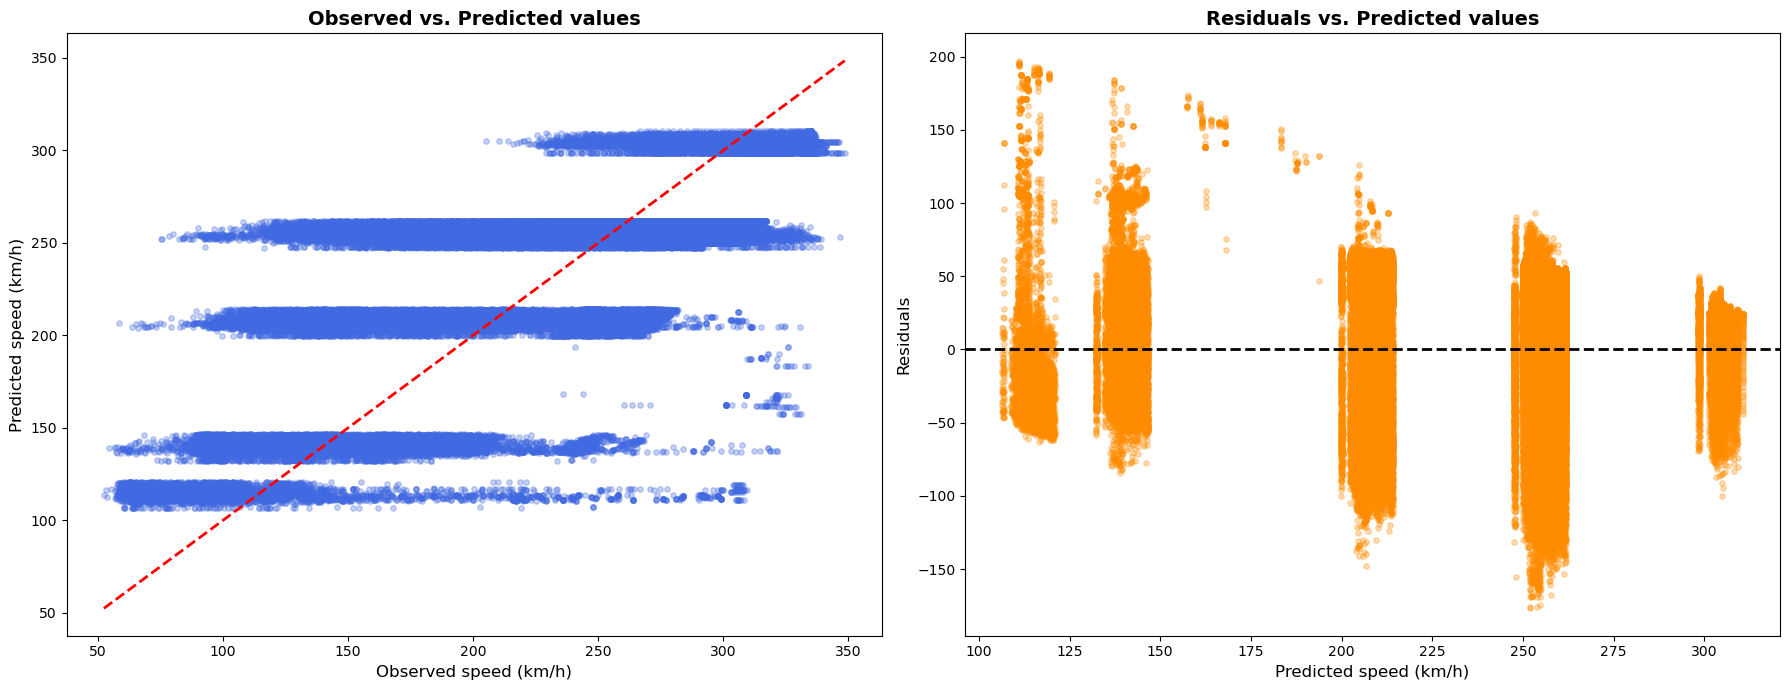

In [25]:
# DIAGNOSTIC PLOTS
y_pred = final_results.fittedvalues
residuals = final_results.resid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot A: Observed vs Predicted values
ax1.scatter(y, y_pred, alpha=0.3, color='royalblue', s=15)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Observed speed (km/h)', fontsize=12)
ax1.set_ylabel('Predicted speed (km/h)', fontsize=12)
ax1.set_title('Observed vs. Predicted values', fontsize=14, fontweight='bold')

# Plot B: Residual analysis
ax2.scatter(y_pred, residuals, alpha=0.3, color='darkorange', s=15)
ax2.axhline(0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted speed (km/h)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residuals vs. Predicted values', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

L'analisi di questi due grafici è fondamentale e la risposta è un **SÌ assoluto**: l'uso di un modello **D-STEM** (o comunque un approccio basato su modelli spazio-temporali dinamici come quelli di Finazzi e Fassò) è non solo sensato, ma quasi **necessario** per una tesi o un'analisi scientifica di alto livello.

Ecco perché i tuoi grafici gridano "D-STEM" e cosa sta succedendo:

### 1. Il problema delle "Bande Orizzontali" (Grafico a sinistra)
Guarda la forma del plot *Osservati vs Predetti*. Invece di una nuvola diagonale, vedi dei **cluster orizzontali**.
*   **Cosa significa:** Il tuo modello OLS attuale sta predicendo solo pochi "livelli" di velocità (corrispondenti alle tue categorie: Straight, HighSpeed, Medium, Slow, Hairpin). 
*   **Il limite dell'OLS:** L'OLS non capisce la continuità fisica. Tratta ogni punto del tracciato come un'osservazione indipendente. Ma un pilota non passa istantaneamente da "Slow" a "Straight"; c'è un'inerzia, una dinamica. 
*   **Perché D-STEM:** Il D-STEM gestisce le variabili come **processi stocastici nello spazio e nel tempo**. Invece di avere 5 gradini, il D-STEM modellerebbe la velocità come un profilo continuo che evolve giro dopo giro.

### 2. La struttura dei residui (Grafico a destra)
Il grafico dei residui è il "colpevole" principale. Non è una nuvola casuale (come dovrebbe essere), ma ha delle **linee diagonali marcate** all'interno di ogni cluster.
*   **Diagnosi:** C'è una fortissima **autocorrelazione spaziale e temporale** non catturata. La velocità al metro 100 dipende fortemente dalla velocità al metro 90. L'OLS ignora questa dipendenza "vicinale".
*   **Eteroschedasticità:** L'errore aumenta o diminuisce a seconda della zona del tracciato (le bande hanno larghezze diverse). Il degrado gomme non colpisce allo stesso modo un rettilineo e un tornante. 
*   **Il vantaggio di D-STEM:** Il framework di Finazzi-Fassò è nato esattamente per gestire dati ambientali e fisici dove le variabili dipendono dalla posizione (spazio) e dal momento (tempo/giro). Permette di modellare l'errore non come "rumore bianco", ma come un **campo aleatorio** che ha una sua struttura.

### 3. Studiare la relazione Degrado Gomme - Velocità con D-STEM
Usando il D-STEM, la tua domanda di ricerca cambia marcia:
1.  **Coefficienti dinamici:** Invece di un unico numero per il degrado (`-0.068`), il D-STEM può dirti se il degrado sta accelerando negli ultimi giri (dinamica temporale) o se è più punitivo nel terzo settore di Abu Dhabi rispetto al primo (dinamica spaziale).
2.  **Variabili Latenti:** Il D-STEM può stimare variabili che non misuriamo direttamente (es. l'evoluzione del grip della pista o lo stile di guida che cambia per proteggere le gomme) trattandole come componenti latenti.
3.  **Precisione:** Ridurresti drasticamente quell'RSE (errore medio), perché il modello "imparerebbe" la forma del circuito come un continuum e non come una serie di pezzi separati.

### Conclusione
Il tuo modello OLS attuale ha fatto un ottimo lavoro nel **identificare i driver principali** (abbiamo visto che le variabili sono significative), ma i grafici mostrano che la **forma funzionale** del modello è troppo rigida per la fisica della F1.

Passare a un modello **D-STEM** ti permetterebbe di:
*   Eliminare quei pattern strutturati nei residui.
*   Studiare il degrado gomme non come un calo fisso, ma come un **processo degradativo spazio-temporale**.
*   Dare alla tua tesi un valore metodologico molto più alto (usando uno stato dell'arte della statistica spaziale italiana).

**In breve:** Se vuoi veramente capire come il degrado gomme interagisce con la prestazione, l'OLS ti dà la media, il D-STEM ti dà la **fisica del processo**.